## Parameters
Golovin Kernel, B = 1500 / sec

**Collocation**
```
    ############################ SETUP ###################################
    casename = "examples/largerIC_golovin_16_"

    ############################ SETUP ###################################
    casename = "examples/largerIC_golovin_16_"

    # Numerical parameters
    FT = Float64
    tspan = (0.0, 3600.0)

    # basis setup 
    Nb = 16
    rmax  = 200.0
    rmin  = 2.0
    vmin = 4/3*pi*rmin^3
    vmax = 4/3*pi*rmax^3

    r_cutoff = 25
    v_cutoff = 4/3*pi*r_cutoff^3

    # Physical parameters: Kernel
    a = 0.0
    b = 1500 * 1e-12
    c = 0.0    
    r = v->(3/4/pi*v)^(1/3)
    area = v->4*pi*r(v)^2
    kernel_func = x -> a + b*(x[1]+x[2]) + c*(r(x[1])+r(x[2]))^2*abs(area(x[1])-area(x[2]))
    tracked_moments = [1.0]
    inject_rate = 0
    N     = 100           # initial droplet density: number per cm^3
    θ_v   = 1000          # volume scale factor: µm^3
    θ_r   = 3             # radius scale factor: µm
    k     = 3             # shape factor for particle size distribution 
    ρ_w   = 1.0e-12       # density of droplets: 1 g/µm^3
```

**Bott**
```
Tmax, nbin, dt, scal, emin, rhow, B, k1, theta, N0 
[7200, 32, 1.0, 1, 7.091336e-10, 1e-09, 1.5e-12, 3, 1000, 100]
gmin = 1e-10
```

## PySDM

In [1]:
import sys, os
os.environ["NUMBA_DISABLE_JIT"] = "1"

import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Collision
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity, UniformRandom

from PySDM.products.size_spectral import ParticleVolumeVersusRadiusLogarithmSpectrum, ParticleSizeSpectrumPerVolume
import PySDM.products.size_spectral.arbitrary_moment as am
from PySDM.products.housekeeping.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Gamma
from PySDM.dynamics.collisions.collision_kernels import ConstantK, Golovin
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.dynamics.collisions.breakup_efficiencies import ConstEb
from PySDM.dynamics.collisions.breakup_fragmentations import AlwaysN
from PySDM.physics.constants import si
from PySDM.physics.constants_defaults import rho_w, rho_STP
from PySDM import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'default'

from scipy.stats import gamma

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (idx, array[idx])

In [3]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**16
        self.n_part = 100 / si.cm**3
        self.k = 3
        self.theta = 1000 * si.um**3
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 100 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 3600.0]
        self.kernel = Golovin(b=1500 / si.second)
        self.coal_eff = ConstEc(Ec=1.0)
        self.fragmentation = AlwaysN(n=1)
        self.break_eff = ConstEb(0.0) # no "bouncing"
        self.spectrum = Gamma(norm_factor=self.norm_factor, theta=self.theta, k=self.k)
        self.radius_bins_edges = np.logspace(np.log10(1 * si.um), np.log10(1000 * si.um), num=128, endpoint=True)
        self.volume_bins_edges = self.radius_bins_edges**3 * 4 * np.pi / 3
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

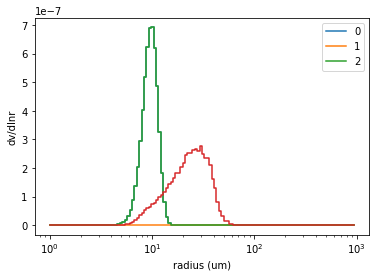

In [4]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
# env['rhod'] = 1
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
products = [dvdlnr, nv]
core = builder.build(attributes, products)
sdm_y = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_y1 = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
i = 0
v_cutoff = 1e3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]
dr = settings.radius_bins_edges[1:] - settings.radius_bins_edges[:-1]
for step in settings.output_steps:
    core.run(step - core.n_steps)
    sdm_y[:,i] = core.products['N(v)'].get() * si.cm**3 * dr
    sdm_y1[:,i] = core.products['dv/dlnr'].get()[0]
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.um, 
            y=sdm_y1,
            where='post', label="t = {step*settings.dt}s")
    i += 1
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dv/dlnr")
pyplot.legend([0, 1, 2])
#pyplot.xlim([1e1, 1e6])

In [5]:
dlnr = np.mean(np.log(settings.radius_bins_edges[1:]) - np.log(settings.radius_bins_edges[:-1]))

In [6]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd) #UniformRandom(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)

M0 = am.make_arbitrary_moment_product(rank=0, attr='volume', attr_unit='dimensionless')(name='M0')
M1 = am.make_arbitrary_moment_product(rank=1, attr='volume', attr_unit='m^3')(name='M1')
M2 = am.make_arbitrary_moment_product(rank=2, attr='volume', attr_unit='m^6')(name='M2')
Nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
products = [M0, M1, M2, Nv, dvdlnr]
core = builder.build(attributes, products)
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
dx_sdm = np.diff(np.append([0.0], sdm_x))

r_cutoff = 25
v_cutoff = 4/3*np.pi*r_cutoff**3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]

mom0 = np.zeros(int(settings._steps[-1]/settings.dt))
mom1 = np.zeros(int(settings._steps[-1]/settings.dt))
mom2 = np.zeros(int(settings._steps[-1]/settings.dt))
sdm_precip = np.zeros(int(settings._steps[-1]/settings.dt))
i = 0
for step in range(int(settings._steps[-1]/settings.dt)):
    core.run(step - core.n_steps)
    mom0[i] = M0.get()
    mom1[i] = M1.get() 
    mom2[i] = M2.get()
    dvdlnr_instant = core.products['dv/dlnr'].get()[0] * si.cm**3 / si.um**3
    mv_instant = dvdlnr_instant*dlnr

    sdm_precip[i] = np.sum(mv_instant[bin_cutoff:])
    i += 1
times_sdm = range(0,int(settings._steps[-1]),int(settings.dt))


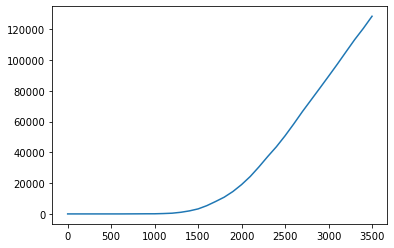

In [7]:
pyplot.plot(times_sdm, sdm_precip)

## Bin

In [8]:
# golovin_IC1
# Tmax, nbin, dt, scal, emin, rhow, A, k1, theta, N0 
# [3600.0, 32, 1.0, 1, 7.091336e-10, 1e-09, 1.5e-09, 3, 1000, 100]

v_grid = [1.06370040e+00, 2.12740080e+00, 4.25480160e+00, 8.50960320e+00,
 1.70192064e+01, 3.40384128e+01, 6.80768256e+01, 1.36153651e+02,
 2.72307302e+02, 5.44614605e+02, 1.08922921e+03, 2.17845842e+03,
 4.35691684e+03, 8.71383368e+03, 1.74276674e+04, 3.48553347e+04,
 6.97106694e+04, 1.39421339e+05, 2.78842678e+05, 5.57685355e+05,
 1.11537071e+06, 2.23074142e+06, 4.46148284e+06, 8.92296569e+06,
 1.78459314e+07, 3.56918627e+07, 7.13837255e+07, 1.42767451e+08,
 2.85534902e+08, 5.71069804e+08, 1.14213961e+09, 2.28427922e+09]
r_grid = [6.33252487e-01, 7.97848139e-01, 1.00522566e+00, 1.26650497e+00,
 1.59569628e+00, 2.01045133e+00, 2.53300995e+00, 3.19139256e+00,
 4.02090266e+00, 5.06601990e+00, 6.38278511e+00, 8.04180532e+00,
 1.01320398e+01, 1.27655702e+01, 1.60836106e+01, 2.02640796e+01,
 2.55311404e+01, 3.21672213e+01, 4.05281592e+01, 5.10622809e+01,
 6.43344425e+01, 8.10563184e+01, 1.02124562e+02, 1.28668885e+02,
 1.62112637e+02, 2.04249124e+02, 2.57337770e+02, 3.24225274e+02,
 4.08498247e+02, 5.14675540e+02, 6.48450547e+02, 8.16996494e+02]

gr0 = [1.91825611e-007, 3.06594679e-006, 4.89508996e-005, 7.79889052e-004,
 1.23724906e-002, 1.94619238e-001, 3.00969894e+000, 4.49860279e+001,
 6.28155044e+002, 7.65464890e+003, 7.10431387e+004, 3.82468690e+005,
 6.92824760e+005, 1.42088340e+005, 3.73515426e+002, 1.61320203e-004,
 1.88074197e-018, 1.59768126e-047, 7.20596272e-107, 9.16169370e-227,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]
gr7 = [1.28407317e-07, 2.05210249e-06, 3.27560499e-05, 5.21622716e-04,
 8.26735254e-03, 1.29797521e-01, 1.99961458e+00, 2.96610261e+01,
 4.07893770e+02, 4.82139679e+03, 4.21885477e+04, 2.09034004e+05,
 4.30217174e+05, 3.74575869e+05, 1.90075870e+05, 4.24784992e+04,
 3.22377401e+03, 7.40206402e+01, 6.01773596e-01, 2.35307751e-03,
 2.78874828e-06, 1.99433018e-11, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
gr30 = [3.43516309e-08, 5.48884884e-07, 8.75817450e-06, 1.39366456e-04,
 2.20560430e-03, 3.45260030e-02, 5.28766263e-01, 7.75137558e+00,
 1.04109832e+02, 1.17399540e+03, 9.37872608e+03, 4.04626278e+04,
 8.28320538e+04, 1.20766149e+05, 1.68791035e+05, 2.20284200e+05,
 2.52727966e+05, 2.26249658e+05, 1.30593998e+05, 3.86224906e+04,
 4.87205441e+03, 2.55289117e+02, 6.67298277e+00, 1.08289524e-01,
 7.38228270e-04, 3.68399752e-10, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
t_bott = [   0.,  120.,  240.,  360.,  480.,  600.,  720.,  840.,  960., 1080.,
 1200., 1320., 1440., 1560., 1680., 1800., 1920., 2040., 2160., 2280.,
 2400., 2520., 2640., 2760., 2880., 3000., 3120., 3240., 3360., 3480.,
 3600.]
M0_bott = [100.01643568,  94.9671906 ,  90.13237259,  85.51599588,  81.1139864 ,
  76.92011691,  72.92727687,  69.12797058,  65.51456355,  62.07942203,
  58.81499785,  55.71388197,  52.76883945,  49.97283291,  47.31903851,
  44.80085629,  42.41191648,  40.14608257,  37.99745202,  35.96035518,
  34.02935269,  32.19923189,  30.46500221,  28.82188989,  27.26533222,
  25.79097137,  24.39464792,  23.07239431,  21.82042805,  20.63514499,
  19.51311249]
M1_bott = [299700.54085184, 299700.54085184, 299700.54085184, 299700.54085183,
 299700.54085183, 299700.54085183, 299700.54085181, 299700.54085181,
 299700.54085181, 299700.54085181, 299700.54085179, 299700.54085178,
 299700.54085178, 299700.54085177, 299700.54085176, 299700.54085172,
 299700.54085171, 299700.54085171, 299700.54085171, 299700.5408517 ,
 299700.54085167, 299700.5408516 , 299700.54085161, 299700.54085161,
 299700.5408516 , 299700.54085159, 299700.54085154, 299700.54085146,
 299700.54085146, 299700.54085145, 299700.54085145]
M2_bott = [1.19640534e+09, 1.32274452e+09, 1.46503116e+09, 1.62404565e+09,
 1.80145733e+09, 1.99926889e+09, 2.21976162e+09, 2.46549683e+09,
 2.73933735e+09, 3.04447888e+09, 3.38448687e+09, 3.76333753e+09,
 4.18546375e+09, 4.65580726e+09, 5.17987731e+09, 5.76381601e+09,
 6.41447068e+09, 7.13947427e+09, 7.94733532e+09, 8.84753871e+09,
 9.85065816e+09, 1.09684814e+10, 1.22141490e+10, 1.36023096e+10,
 1.51492925e+10, 1.68733018e+10, 1.87946316e+10, 2.09359062e+10,
 2.33223475e+10, 2.59820726e+10, 2.89464264e+10]
mprecip_bin = [3.69142754e-48, 4.88233367e-05, 3.47496270e-03, 4.85678712e-02,
 3.38432900e-01, 1.58758008e+00, 5.74334289e+00, 1.72419829e+01,
 4.48925533e+01, 1.04332227e+02, 2.20783403e+02, 4.31620923e+02,
 7.88106123e+02, 1.35563704e+03, 2.21203808e+03, 3.44374651e+03,
 5.14016978e+03, 7.38687520e+03, 1.02585285e+04, 1.38125545e+04,
 1.80843490e+04, 2.30845763e+04, 2.87987252e+04, 3.51887536e+04,
 4.21963957e+04, 4.97475638e+04, 5.77572528e+04, 6.61344209e+04,
 7.47864402e+04, 8.36228546e+04, 9.25583164e+04]

In [9]:
gr_0 = np.array(gr0)
gr_f = np.array(gr30) # um**3/cm3
r_grid = np.array(r_grid)
r_grid = np.insert(r_grid, 0, 0.0)

In [10]:
v_grid_plt = np.array(v_grid)*np.sqrt(2)
r_grid_plt = (v_grid_plt / 4 / np.pi * 3)**(1/3)

## Cloudy

In [11]:
# import rbf from julia setup
from scipy.stats import norm
from scipy.stats import gamma

def cslogrbf1(x, mean, stddev):
    r = abs((np.log(x)-mean)/stddev)
    cslogr = np.zeros(len(x))
    for (i, ri) in enumerate(r):
        if (ri < 1):
            cslogr[i] = 12/35*(1-ri)**4 * (4+16*ri+12*ri**2+3*ri**3)/x[i]/stddev
    return cslogr

def rbf_basis(x, constants, means, stddev):
    N = len(means)
    assert (len(stddev) == N)
    assert (len(constants) == N)
    pdf_result = 0
    
    for i in range(N):
        pdf_result += constants[i]*cslogrbf1(x, means[i], stddev[i])
        
    return pdf_result

def rbf8_i(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_init = [0.004135265524792927, 0.0005102295782039245, 93.74565285439733, 0.0013986822574497818, 0.0015365672674443561, 0.0005833978918138448, 0.00011294525917966467, 9.07768418415214e-5]
    return rbf_basis(x, c_init, means, stddevs)

def rbf8_f(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_final = [0.0, 1.2253609819455613, 12.183593021623215, 3.6418349235727243, 0.8811085695499952, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)

def rbf16_i(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_init = [0.0, 0.0, 0.0, 0.0, 23.83850331725102, 69.9059778137361, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_init, means, stddevs)

def rbf16_f(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [6.85987215031428, 6.85987215031428, 1.1982929094215962, 1.198292909421597, 1.198292909421597, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962, 1.1982929094215962]
    c_final = [0.0, 0.0, 0.0, 0.0, 4.425964974415094, 6.569487627720401, 3.855961003383557, 2.3216433149153306, 1.20973369779914, 0.44112933827467976, 0.03472644342251575, 0.0, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)
    
#import cloudy from julia setup
# initial N, k, theta = 100.0, 3.0, 1000.0, 
# final N, k, theta = 19.78986990868377, 0.1742933437164949, 86975.61608607811, 
def mom_f(x):
    n = 19.78986990868377
    k = 0.1742933437164949
    theta = 86975.61608607811
    return n*gamma.pdf(x, k, scale=theta)
def mom_i(x):
    n =100.0
    k =3.0
    theta =1000.0
    return n*gamma.pdf(x, k, scale=theta)
    

In [12]:
col_8_times = [0.0, 0.12647230744114374, 0.28221571624617514, 0.4909716933907511, 0.7238572824164479, 1.7305263606544408, 2.4186441358273116, 4.817255256008851, 7.047282130436348, 10.27702869279391, 13.848190566102826, 18.421997276900537, 21.954482063876423, 30.09905366497589, 37.825852144181766, 48.940631568310685, 65.90646141217685, 88.86599934518398, 116.39825114296008, 150.28091018659384, 186.63849715272642, 232.19788022538572, 266.6949182443918, 296.6253031703017, 317.4647142312259, 502.88678623722814, 601.9684441585786, 937.7235474881365, 1096.4076178178782, 1242.0219477951268, 1361.9678694749302, 1427.639516987167, 1491.5665970343625, 1564.2650891026983, 1614.3600449441471, 1662.0137263510037, 1703.2743880903865, 1750.479796880742, 1791.8069671453857, 1845.542094944807, 2054.7683272427403, 2289.974660558757, 2650.781970862955, 3181.3648438732034, 3600.0]
col_8_M_0 = [93.75184870100259, 93.74662135873527, 93.740235766147, 93.73202352637225, 93.72284785681065, 93.68347255899056, 93.65671725335103, 93.56362952766871, 93.47719853835581, 93.35201862608741, 93.21344804322293, 93.03559201628818, 92.89791675386653, 92.57938134185164, 92.27579139652637, 91.8368369112803, 91.16209365329863, 90.24098493562, 89.12638521988461, 87.74335741239531, 86.25026293592954, 84.37377504753623, 82.95402582561059, 81.72601829833154, 80.87428537578818, 73.5066728730041, 69.7889783493427, 58.63225676845219, 54.14985686182911, 50.45079157695795, 47.67714876221831, 46.25547994444073, 44.93339933171528, 43.500508624579965, 42.554670108675815, 41.684977935522745, 40.95480019460022, 40.14440956038676, 39.47308446000894, 38.61468113722917, 35.31275326344763, 31.776854905300155, 26.924284689549424, 21.219704469209123, 17.800737348496416]
col_8_M_1 = [299998.6241512039, 299551.63109253516, 299251.4782707982, 299601.6812193179, 300051.18450937927, 300343.3583935896, 300161.7720936517, 299904.6910230607, 300008.8883182038, 300469.24108911376, 301182.51271008095, 302204.42895119026, 303038.40998277924, 304956.92688143527, 306740.1854871028, 309234.8007396038, 312880.1243213403, 317504.94521697884, 322596.438669389, 328210.43259756424, 333469.2755227082, 339016.21803233214, 342495.6606031502, 345042.6795567927, 346573.0718463085, 352720.33998039935, 351656.35505372816, 334947.46333198325, 323292.55401036335, 311773.40865501284, 302076.72617949476, 296788.1075231567, 291587.25525811076, 285779.47477944766, 281821.16604051064, 278094.8267014152, 274914.1315069411, 271300.6102289931, 273271.11327662255, 278721.0203231329, 295266.9150303627, 305299.91255709116, 306283.8896189245, 288445.85093852546, 267623.9208642733]
col_8_M_2 = [3.0305074336573875e10, 2.040324985121912e10, 1.3603138523058477e10, 1.9636830377191486e10, 2.8306699052304504e10, 3.355140827294852e10, 2.880295187614937e10, 1.7315993173802483e10, 1.127818335014568e10, 6.758627415657882e9, 4.610516106951999e9, 3.4872170889717736e9, 3.354134284133753e9, 3.4387228946522593e9, 3.601213308678053e9, 3.863292787240699e9, 4.269663810953962e9, 4.801588958697684e9, 5.404388777956238e9, 6.1164763515007105e9, 6.787510563865108e9, 7.580803037054423e9, 8.140696387492524e9, 8.568314938262629e9, 8.856083189899706e9, 1.082587764523979e10, 1.1514560975517616e10, 1.2590103483723133e10, 1.2659518907059845e10, 1.2577139843761213e10, 1.260752694273166e10, 1.295431324501165e10, 1.2233339241667425e10, 1.2102452307272388e10, 1.200687760432143e10, 1.1912611900361174e10, 1.1983172962536848e10, 1.1846542859815214e10, 1.411703588518681e10, 1.866171123977411e10, 3.453185815214009e10, 4.855775082586598e10, 6.257048247459914e10, 7.090218636893942e10, 7.141269620800867e10]

col_16_times = [0.0, 0.15976131006551833, 0.48416419578100867, 3.7281930529359113, 32.24952115122667, 98.71468927482609, 186.61882431891502, 293.00608482659266, 430.7480447405636, 568.3748900712418, 813.322175243366, 997.8065022591119, 1279.2774829637992, 1572.7885427570973, 1786.3954458041112, 2216.420869347, 2591.4957451874875, 2926.5206353876297, 3286.987956330735, 3600.0]
col_16_M_0 = [93.7444811231555, 93.73781992866219, 93.72542579965811, 93.60136003074352, 92.5016092754606, 89.89167153988566, 86.39257544962396, 82.17899965520078, 76.8934555293304, 71.90866411052212, 64.35393758551122, 59.14125369505106, 51.95907170910756, 45.562333644893286, 41.41937874768712, 34.20682558617749, 29.06140276343678, 25.126792362965897, 21.52316612678578, 18.858646398355223]
col_16_M_1 = [304439.9067222589, 304448.1258493067, 304478.38307372644, 304777.74432992394, 307164.45638526126, 311143.43024527165, 313481.35827092105, 312787.8987505792, 307791.28602549096, 300003.0136654688, 302407.39839732624, 302201.4176368107, 295674.3368415238, 294040.76861087524, 294315.5802471841, 287417.8206024699, 286733.513866175, 285258.8366383703, 278698.2238431601, 279427.3438484712]
col_16_M_2 = [1.4027889954074328e9, 1.4032057038698897e9, 1.4042411116691842e9, 1.414545295432384e9, 1.5013053567178817e9, 1.6782852567260034e9, 1.8641005585472434e9, 2.0275437224332175e9, 2.166388428740675e9, 2.29094199873429e9, 3.0166651484980807e9, 3.5609556969869423e9, 4.1530228942408023e9, 5.505223427755038e9, 6.77387145662636e9, 8.786327004432638e9, 1.2725864643281982e10, 1.670188057204555e10, 2.008314536155095e10, 2.806763814425074e10]


In [13]:
t_cloudy = [0.0, 0.04439602699502933, 0.48835629694532257, 4.927958996448254, 27.111377446126376, 63.16297300308953, 104.96792362288865, 156.87174926031363, 215.7052007065487, 282.32817258573476, 355.085802996134, 433.6244871047605, 516.9001276737463, 604.3048074841654, 695.1116051167998, 788.7780763173615, 884.7875196163827, 982.7330634704647, 1082.254636268254, 1183.0637541862538, 1284.9175792732603, 1387.6192822380294, 1491.0068125743487, 1594.9487741307291, 1699.3381552599326, 1804.0883706468053, 1909.1293045523248, 2014.4043431229716, 2119.8677932176283, 2225.482833248539, 2331.219785765549, 2437.0547713957094, 2542.9685525031996, 2648.9456861954995, 2754.9737319065903, 2861.04269210365, 2967.1445337300183, 3073.272812725615, 3179.422325146572, 3285.5889190085554, 3391.7692211362255, 3497.960567533721, 3600.0]
M0_cloudy = [100.0, 99.99800219874155, 99.9780263811908, 99.77848754690122, 98.78739998820193, 97.19768051202895, 95.38626738608238, 93.18417385231926, 90.7494893080983, 88.06916822744545, 85.2323941533365, 82.27268579819896, 79.24664904624083, 76.1902134950268, 73.13960145866966, 70.12084085556313, 67.15583419123172, 64.26018980764115, 61.44580701981384, 58.72065251792138, 56.089984956553785, 53.55673230562473, 51.12211182434464, 48.785992739681895, 46.54725420836273, 44.4040383531974, 42.35396320729474, 40.39428164829611, 38.522006640649195, 36.73400566909493, 35.02707319739285, 33.39798399966922, 31.84353368451285, 30.360566968685884, 28.945999462362128, 27.596831752377916, 26.310159196242758, 25.083177950441332, 23.913188807563223, 22.79759783848833, 21.73391701651512, 20.71976199533607, 19.789869908683766]
M1_cloudy = [300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0, 300000.0]
M2_cloudy = [1.2e9, 1.2000479486670768e9, 1.2005275407247343e9, 1.205334015587074e9, 1.2296404339129646e9, 1.2701922062165043e9, 1.3188929204341998e9, 1.3819646292451313e9, 1.457111771074558e9, 1.5471536874377997e9, 1.6518548028442857e9, 1.7728414443392472e9, 1.9108184759577289e9, 2.067201754934852e9, 2.2432416870457335e9, 2.440546099454108e9, 2.660809299611639e9, 2.906010894107396e9, 3.178313561362587e9, 3.4801623174453607e9, 3.8142626832544255e9, 4.1836284110037413e9, 4.59159605593281e9, 5.041861976556593e9, 5.538512133244122e9, 6.086061098092624e9, 6.689491960196564e9, 7.35430213005333e9, 8.086553098802959e9, 8.892925801871416e9, 9.780781259433786e9, 1.0758227937180653e10, 1.1834195381859634e10, 1.3018516297879503e10, 1.4322015743367662e10, 1.5756610319115778e10, 1.7335417056787334e10, 1.907287347436252e10, 2.098486890766364e10, 2.30888908047061e10, 2.5404183272635914e10, 2.795192493835817e10, 3.064046611065686e10]

## Plotting

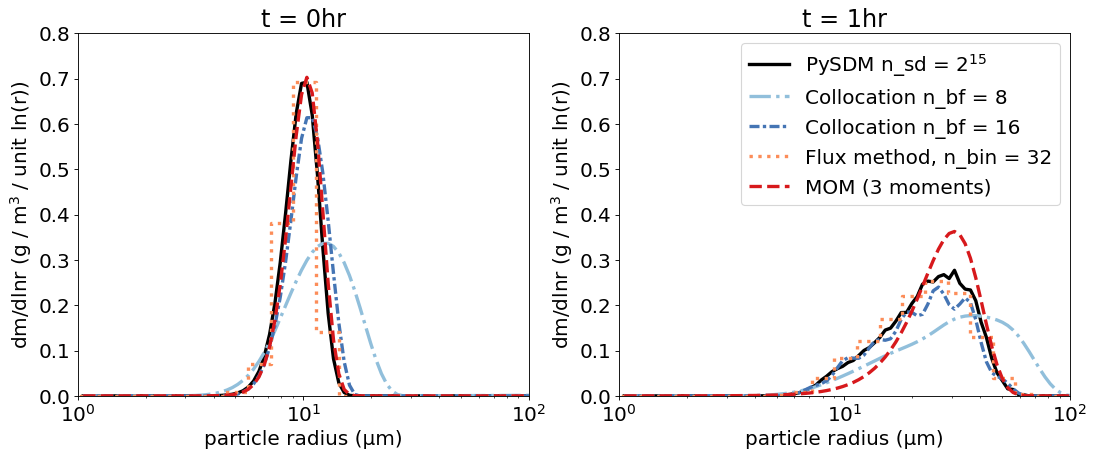

In [14]:
# plot all of them
pyplot.rcParams.update({'font.size':18})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(16,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM sdm_y1: m^3 / m^3 / (unit ln R) --> 1e6 g / m^3 / unit ln R
r_sdm = settings.radius_bins_edges[1:] / si.um
dlnr_sdm = np.log(r_sdm[2]) - np.log(r_sdm[1])

ax[0].plot(r_sdm, sdm_y1[:,0] * 1e6, linestyle=ls[0], color=colors[0], linewidth=3)
ax[1].plot(r_sdm, sdm_y1[:,-1] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)


# COLLOCATION: (um^6 / cm^3) -> 
x = settings.volume_bins_edges[:-1]/si.um**3
yrbf8i = rbf8_i(x)
yrbf8f = rbf8_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf8i * si.cm**3, linestyle=ls[1],color=colors[1],linewidth=3)#, label='Collocation n_bf = 8, init')
ax[1].plot(r_sdm, 3*x*x*yrbf8f * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)
yrbf16i = rbf16_i(x)
yrbf16f = rbf16_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf16i * si.cm**3, linestyle=ls[2],color=colors[2],linewidth=3)#, label='Collocation n_bf = 16, init')
ax[1].plot(r_sdm, 3*x*x*yrbf16f * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].step(r_grid_plt,
            gr_0 * si.cm**3,
            linestyle=ls[3],color=colors[3],linewidth=3)#, label='Flux method, n_bin = 32, init')
ax[1].step(r_grid_plt,  
            gr_f * si.cm**3,
            linestyle=ls[3],color=colors[3], label='Flux method, n_bin = 32',linewidth=3)


# BULK: (um^3 / cm^3) / (um^3)
ymomi = mom_i(x)
ymomf = mom_f(x)
ax[0].plot(r_sdm, 3*x*x*ymomi * si.cm**3, linestyle=ls[4],color=colors[4],linewidth=3)#, label="MOM (3 moments), init")
ax[1].plot(r_sdm, 3*x*x*ymomf * si.cm**3, linestyle=ls[4],color=colors[4], label="MOM (3 moments)",linewidth=3)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel("particle radius (µm)")
#ax[0].set_ylabel("volume density µm$^3$/cm$^3$ per um$^3$")
ax[0].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[1].set_xlabel("particle radius (µm)")
ax[1].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[0].set_xlim([1.0, 100.0])
ax[1].set_xlim([1.0, 100.0])
ax[0].set_ylim([0.0, 0.8])
ax[1].set_ylim([0.0, 0.8])
ax[1].legend()

ax[0].set_title('t = 0hr')
ax[1].set_title('t = 1hr')

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')

#ax[0].grid()
#ax[1].grid()

pyplot.savefig("m(v)_golovin_IC1.pdf", transparent=True)

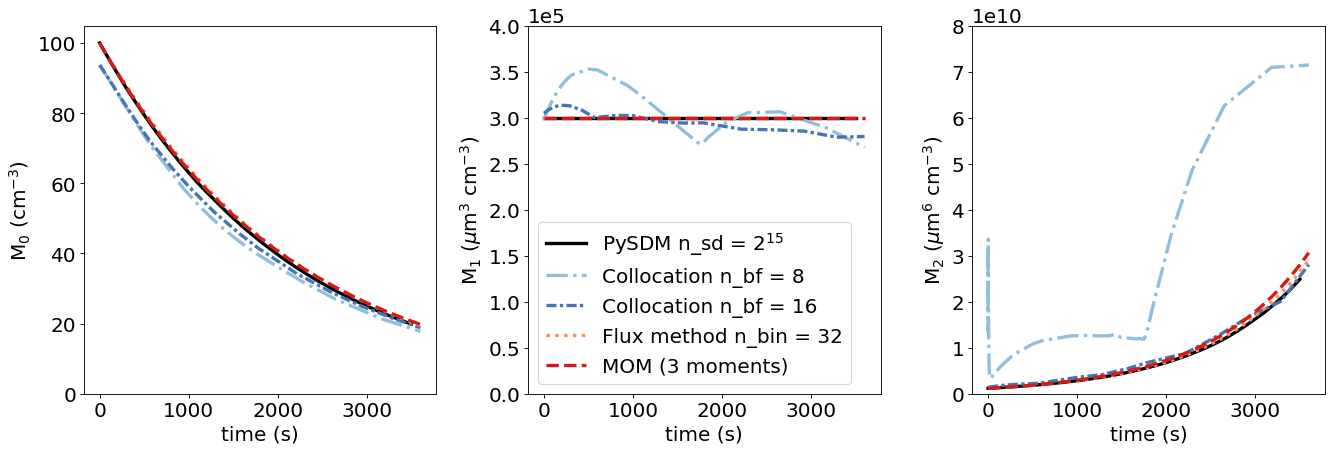

In [15]:
# plot all of them
from matplotlib.ticker import ScalarFormatter
xfmt = ScalarFormatter()
xfmt.set_powerlimits((-3,3))  # Or whatever your limits are . . .

fig, ax = pyplot.subplots(nrows=1, ncols=3, figsize=(17,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM:
ax[0].plot(times_sdm, mom0*si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
ax[1].plot(times_sdm, mom1 / si.um**3 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[2].plot(times_sdm, mom2 / si.um**6 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)

# COLLOCATION:
ax[0].plot(col_8_times, col_8_M_0, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[1].plot(col_8_times, col_8_M_1, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[2].plot(col_8_times, col_8_M_2, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)

ax[0].plot(col_16_times, col_16_M_0, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[1].plot(col_16_times, col_16_M_1, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[2].plot(col_16_times, col_16_M_2, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].plot(t_bott, M0_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[1].plot(t_bott, M1_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[2].plot(t_bott, M2_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)

# # BULK: (um^3 / cm^3) / (um^3)
ax[0].plot(t_cloudy, M0_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)
ax[1].plot(t_cloudy, M1_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)
ax[2].plot(t_cloudy, M2_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)

ax[0].set_xlabel('time (s)')
ax[1].set_xlabel('time (s)')
ax[2].set_xlabel('time (s)')
ax[0].set_ylabel('M$_0$ (cm$^{-3}$)')
ax[1].set_ylabel('M$_1$ ($\mu$m$^3$ cm$^{-3}$)')
ax[2].set_ylabel('M$_2$ ($\mu$m$^6$ cm$^{-3}$)')
ax[0].set_ylim([0, 105])
ax[1].set_ylim([0, 4e5])
ax[2].set_ylim([0, 8e10])
ax[1].legend()
ax[1].yaxis.set_major_formatter(xfmt)

pyplot.tight_layout()
pyplot.savefig("moments_golovin_IC1.pdf", transparent=True)


In [16]:
volume_cutoff = 4/3*np.pi*r_cutoff**3

In [17]:
t_precip_16 = [0.0, 36.36363636363637, 72.72727272727273, 109.0909090909091, 145.45454545454547, 181.8181818181818, 218.1818181818182, 254.54545454545453, 290.90909090909093, 327.27272727272725, 363.6363636363636, 400.0, 436.3636363636364, 472.72727272727275, 509.09090909090907, 545.4545454545455, 581.8181818181819, 618.1818181818181, 654.5454545454545, 690.9090909090909, 727.2727272727273, 763.6363636363636, 800.0, 836.3636363636364, 872.7272727272727, 909.0909090909091, 945.4545454545455, 981.8181818181819, 1018.1818181818181, 1054.5454545454545, 1090.909090909091, 1127.2727272727273, 1163.6363636363637, 1200.0, 1236.3636363636363, 1272.7272727272727, 1309.090909090909, 1345.4545454545455, 1381.8181818181818, 1418.1818181818182, 1454.5454545454545, 1490.909090909091, 1527.2727272727273, 1563.6363636363637, 1600.0, 1636.3636363636363, 1672.7272727272727, 1709.090909090909, 1745.4545454545455, 1781.8181818181818, 1818.1818181818182, 1854.5454545454545, 1890.909090909091, 1927.2727272727273, 1963.6363636363637, 2000.0, 2036.3636363636363, 2072.7272727272725, 2109.090909090909, 2145.4545454545455, 2181.818181818182, 2218.181818181818, 2254.5454545454545, 2290.909090909091, 2327.2727272727275, 2363.6363636363635, 2400.0, 2436.3636363636365, 2472.7272727272725, 2509.090909090909, 2545.4545454545455, 2581.818181818182, 2618.181818181818, 2654.5454545454545, 2690.909090909091, 2727.2727272727275, 2763.6363636363635, 2800.0, 2836.3636363636365, 2872.7272727272725, 2909.090909090909, 2945.4545454545455, 2981.818181818182, 3018.181818181818, 3054.5454545454545, 3090.909090909091, 3127.2727272727275, 3163.6363636363635, 3200.0, 3236.3636363636365, 3272.7272727272725, 3309.090909090909, 3345.4545454545455, 3381.818181818182, 3418.181818181818, 3454.5454545454545, 3490.909090909091, 3527.2727272727275, 3563.6363636363635, 3600.0]
m_precip_16 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.85654188088307, 102.59220379598501, 174.2271451026015, 250.38941881555579, 320.32885106105954, 136.5841539934006, 304.61664406213015, 475.5359415822287, 647.7567354452844, 819.9833307060206, 991.209648582323, 1160.6640707276888, 1327.5296227330637, 1491.1223741475812, 1650.8637821954774, 1806.2695724641223, 1956.944694546256, 2102.5673763162276, 2242.902741264397, 2377.767359510218, 2507.0255553181187, 2630.5894070974837, 2748.41874740267, 2860.521162932996, 2967.038818328362, 3068.035462492436, 3485.7761949660035, 4883.654721725436, 6342.704503287394, 7843.332704090885, 9377.034056238112, 10937.502616596661, 12519.442157009997, 14115.124436738655, 15717.953184759092, 17321.822811419705, 18921.0343987408, 20510.29570041441, 22084.665130269394, 23639.681116309406, 25171.409976749503, 26676.26513277663, 28151.005384518983, 29592.73491104593, 30998.90327036812, 32367.305399437377, 33696.08161414663, 34983.71760933022, 36229.044458763456, 37431.23943037952, 38589.745662443245, 39702.65130814764, 42223.83167519402, 44794.06000577601, 47383.58232953859, 49982.77372886946, 52583.192796771364, 55177.581636861934, 57759.86586337318, 60325.1546011522, 62868.898384613945, 65384.72080660405, 67867.34733433074, 70311.93830475997, 72714.01284811896, 75069.44888789648, 77374.48314084235, 79625.71111696804, 81820.08711954611, 83954.90782754798, 86027.78550571905, 88036.76828650676, 89980.19417476558, 91856.67236227976, 93665.08322776308, 95404.57833685908, 97074.58044214114, 98674.78348311211, 100205.15258620473, 101852.30651827234, 104398.11195374539, 106925.65667637221, 109429.12367617025, 111903.2455826517, 114343.30466482326, 116745.13283118646, 119105.11162973734, 121420.17224796677]
t_precip_8 = [0.0, 36.36363636363637, 72.72727272727273, 109.0909090909091, 145.45454545454547, 181.8181818181818, 218.1818181818182, 254.54545454545453, 290.90909090909093, 327.27272727272725, 363.6363636363636, 400.0, 436.3636363636364, 472.72727272727275, 509.09090909090907, 545.4545454545455, 581.8181818181819, 618.1818181818181, 654.5454545454545, 690.9090909090909, 727.2727272727273, 763.6363636363636, 800.0, 836.3636363636364, 872.7272727272727, 909.0909090909091, 945.4545454545455, 981.8181818181819, 1018.1818181818181, 1054.5454545454545, 1090.909090909091, 1127.2727272727273, 1163.6363636363637, 1200.0, 1236.3636363636363, 1272.7272727272727, 1309.090909090909, 1345.4545454545455, 1381.8181818181818, 1418.1818181818182, 1454.5454545454545, 1490.909090909091, 1527.2727272727273, 1563.6363636363637, 1600.0, 1636.3636363636363, 1672.7272727272727, 1709.090909090909, 1745.4545454545455, 1781.8181818181818, 1818.1818181818182, 1854.5454545454545, 1890.909090909091, 1927.2727272727273, 1963.6363636363637, 2000.0, 2036.3636363636363, 2072.7272727272725, 2109.090909090909, 2145.4545454545455, 2181.818181818182, 2218.181818181818, 2254.5454545454545, 2290.909090909091, 2327.2727272727275, 2363.6363636363635, 2400.0, 2436.3636363636365, 2472.7272727272725, 2509.090909090909, 2545.4545454545455, 2581.818181818182, 2618.181818181818, 2654.5454545454545, 2690.909090909091, 2727.2727272727275, 2763.6363636363635, 2800.0, 2836.3636363636365, 2872.7272727272725, 2909.090909090909, 2945.4545454545455, 2981.818181818182, 3018.181818181818, 3054.5454545454545, 3090.909090909091, 3127.2727272727275, 3163.6363636363635, 3200.0, 3236.3636363636365, 3272.7272727272725, 3309.090909090909, 3345.4545454545455, 3381.818181818182, 3418.181818181818, 3454.5454545454545, 3490.909090909091, 3527.2727272727275, 3563.6363636363635, 3600.0]
m_precip_8 = [2458.6069207830683, 5490.50984498274, 10573.393694933327, 15326.877411732185, 19761.024800877876, 23881.11941764408, 27705.937878338253, 31241.71592720339, 34506.214076703865, 37511.392504267686, 40270.83701549275, 42798.21448455047, 45106.95408334813, 47210.16909295013, 49120.65575214797, 50850.797866312314, 52412.47154807598, 53817.04704459813, 55075.34700221577, 56197.63641249043, 57193.64962646645, 58072.59212174171, 58843.14050246832, 59513.44249935179, 60091.11696965156, 60583.25389718096, 60996.41881372116, 61336.82377485445, 61610.2739848135, 61822.147685504504, 61977.443763261115, 62080.79412756468, 62136.50010775493, 62148.55272966779, 62120.653016272845, 62056.18110882876, 61958.33483490949, 61830.10447888062, 61674.10280092086, 61546.32119150086, 61288.717826879045, 61063.83519142461, 60827.80831722428, 60559.539731635334, 60295.52015982435, 60036.344324354184, 59691.89226727576, 59392.8201594097, 59064.65205806167, 61879.664387282886, 67869.82096876767, 73683.45269520218, 79312.68995354728, 84751.20006559306, 89993.8375747682, 95036.59788741358, 99876.61727278074, 104512.13990422056, 108942.34101675233, 113167.41186106318, 117188.28057209769, 121006.57268775065, 124624.61114886511, 128045.41609845767, 131272.4060808997, 134309.6283802361, 137161.66142364862, 139833.2673958179, 142329.3922389242, 144655.16565264657, 146815.90109416287, 148817.0957781503, 150664.43067678565, 152363.76690131112, 153920.71462401433, 155340.95640163167, 156630.30951220635, 157794.45818994066, 158838.95362519438, 159769.21396448475, 160590.52431048802, 161308.036722038, 161926.77021412586, 162451.61075790162, 162887.31128067264, 163238.49166590537, 163509.63875322274, 163705.1063384065, 163829.10643675431, 163885.62106020586, 163878.45054829732, 163811.2534177126, 163687.54403362144, 163510.69260968076, 163283.9252080344, 163010.32373931288, 162692.82596263403, 162334.2254856023, 161937.17176430856, 161504.17010333206]

In [18]:
t_precip_mom = [0.0, 36.36363636363637, 72.72727272727273, 109.0909090909091, 145.45454545454547, 181.8181818181818, 218.1818181818182, 254.54545454545453, 290.90909090909093, 327.27272727272725, 363.6363636363636, 400.0, 436.3636363636364, 472.72727272727275, 509.09090909090907, 545.4545454545455, 581.8181818181819, 618.1818181818181, 654.5454545454545, 690.9090909090909, 727.2727272727273, 763.6363636363636, 800.0, 836.3636363636364, 872.7272727272727, 909.0909090909091, 945.4545454545455, 981.8181818181819, 1018.1818181818181, 1054.5454545454545, 1090.909090909091, 1127.2727272727273, 1163.6363636363637, 1200.0, 1236.3636363636363, 1272.7272727272727, 1309.090909090909, 1345.4545454545455, 1381.8181818181818, 1418.1818181818182, 1454.5454545454545, 1490.909090909091, 1527.2727272727273, 1563.6363636363637, 1600.0, 1636.3636363636363, 1672.7272727272727, 1709.090909090909, 1745.4545454545455, 1781.8181818181818, 1818.1818181818182, 1854.5454545454545, 1890.909090909091, 1927.2727272727273, 1963.6363636363637, 2000.0, 2036.3636363636363, 2072.7272727272725, 2109.090909090909, 2145.4545454545455, 2181.818181818182, 2218.181818181818, 2254.5454545454545, 2290.909090909091, 2327.2727272727275, 2363.6363636363635, 2400.0, 2436.3636363636365, 2472.7272727272725, 2509.090909090909, 2545.4545454545455, 2581.818181818182, 2618.181818181818, 2654.5454545454545, 2690.909090909091, 2727.2727272727275, 2763.6363636363635, 2800.0, 2836.3636363636365, 2872.7272727272725, 2909.090909090909, 2945.4545454545455, 2981.818181818182, 3018.181818181818, 3054.5454545454545, 3090.909090909091, 3127.2727272727275, 3163.6363636363635, 3200.0, 3236.3636363636365, 3272.7272727272725, 3309.090909090909, 3345.4545454545455, 3381.818181818182, 3418.181818181818, 3454.5454545454545, 3490.909090909091, 3527.2727272727275, 3563.6363636363635, 3600.0]
m_precip_mom = [5.523858061377992e-19, 3.970245021623907e-17, 1.786934263555314e-15, 5.3956159364619173e-14, 1.1560821101994026e-12, 1.8407877243203766e-11, 2.2632508011876518e-10, 2.2187543391548132e-9, 1.781903495048691e-8, 1.1995993286016954e-7, 6.903876951905262e-7, 3.454500423594853e-6, 1.5249256726142546e-5, 6.0143272505187655e-5, 0.00021429092262243481, 0.0006964812380215058, 0.0020826198611401648, 0.005772714096322742, 0.014932177665448262, 0.036259582343657455, 0.08309692882530495, 0.18058185787857567, 0.3737177778762042, 0.7393710566727252, 1.4032533580368887, 2.5628730298691496, 4.517215283895741, 7.703530835947675, 12.741086929362195, 20.481109457116997, 32.061474562049256, 48.96405019818661, 73.07204740780205, 106.72433767211875, 152.7634853247844, 214.57432495655024, 296.11013027423456, 401.9039180150061, 537.0631463363765, 707.2466912183337, 918.6239478978864, 1177.8167555983796, 1491.8253583202713, 1867.940636900531, 2313.645269735857, 2836.506494517676, 3444.0640402493764, 4143.716444918236, 4942.60850640508, 5847.5234707144455, 6864.7822953575205, 8000.15184011385, 9258.764703275747, 10645.051348008485, 12162.685235342402, 13814.542470988392, 15602.674811860452, 17528.29597551343, 19591.78166197923, 21792.680718787415, 24129.737244366657, 26600.923236950337, 29203.47838320714, 31933.95720999559, 34788.282696619186, 37761.8026549945, 40849.34987915324, 44045.3048729536, 47343.657579718296, 50738.0699737836, 54221.938205379585, 57788.45103160684, 61430.647190851, 65141.470334658195, 68913.81865209271, 72740.59254614767, 76614.7386934088, 80529.28828091125, 84477.3931521676, 88452.357811992, 92447.66590314193, 96457.00491677894, 100474.28668662375, 104493.66317014005, 108509.54100806464, 112516.59206648402, 116509.76034938943, 120484.26827103994, 124435.61925317495, 128359.5978502479, 132252.26973981143, 136109.97843781824, 139929.34063910382, 143707.24179912254, 147440.8288484394, 151127.50248594492, 154764.90995131887, 158350.9353058353, 161883.69014083486, 165361.5046931745]


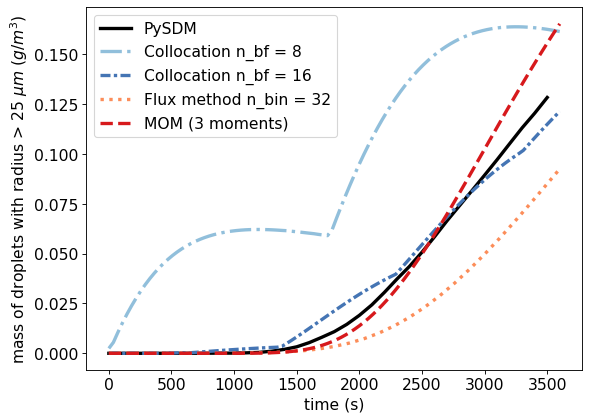

In [19]:
# plot all of them
pyplot.rcParams.update({'font.size':14})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

pyplot.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(times_sdm, sdm_precip[:] / 1e6, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
pyplot.plot(t_precip_8, np.divide(m_precip_8, 1e6), color=colors[1], linestyle=ls[1],label='Collocation n_bf = 8',linewidth=3)
pyplot.plot(t_precip_16, np.divide(m_precip_16, 1e6), color=colors[2], linestyle=ls[2],label='Collocation n_bf = 16',linewidth=3)
pyplot.plot(t_bott, np.divide(mprecip_bin, 1e6), color=colors[3], linestyle=ls[3],label='Flux method n_bin = 32',linewidth=3)
pyplot.plot(t_precip_mom, np.divide(m_precip_mom, 1e6), color=colors[4], linestyle=ls[4],label='MOM (3 moments)',linewidth=3)
pyplot.xlabel('time (s)')
pyplot.ylabel('mass of droplets with radius > 25 $\mu m$ $(g / m^3)$')
pyplot.legend()
pyplot.gca().yaxis.set_major_formatter(xfmt)
pyplot.savefig('m_precip_golovin_IC1.pdf', transparent=True)

## Error Computation

In [41]:
import pickle

def compute_L2_error(y1, y2):
    return np.linalg.norm(y1-y2)/np.linalg.norm(y2)

def bott_m_f(x):
    mf = np.zeros(len(x))
    dlnr_bin = np.mean(np.log(r_grid[3:]) - np.log(r_grid[2:-1]))
    for i in range(len(x)):
        i0 = find_nearest(v_grid,x[i])[0]
        mf[i] = gr_f[i0]#/dlnr_bin*dlnr
    return mf

v_sdm = x

yrbf8f = rbf8_f(v_sdm)
e8f = compute_L2_error(3*yrbf8f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

yrbf16f = rbf16_f(v_sdm)
e16f = compute_L2_error(3*yrbf16f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ymomf = mom_f(v_sdm)
emomf = compute_L2_error(3*ymomf*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ybinf = bott_m_f(v_sdm)
ebinf = compute_L2_error(ybinf*1e-6, sdm_y1[:,-1]*1e6)

print(e8f,e16f,emomf,ebinf)
errs = [e8f, e16f, emomf, ebinf]
pickle.dump(errs, open("golovin_IC1_errors.pkl", "wb" ))

0.5152451880096276 0.18526254687588944 0.3093753620112053 0.13613650973403732
